## Import librarys

In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quandl
import config

## Import data

In [2]:
#spot_p_df = quandl.get("TFGRAIN/SOYBEANS", authtoken="config.quandl_apikey") # Soybeans
spot_p_df = quandl.get("TFGRAIN/CORN", authtoken=config.quandl_apikey) # Corn
spot_p_df.dropna(inplace=True)
N, _ = spot_p_df.shape

In [3]:
futures_p_df = quandl.get("CHRIS/CME_C1", authtoken=config.quandl_apikey)# Corn
#futures_p_df = quandl.get("CHRIS/CME_S1", authtoken="config.quandl_apikey") # Soybeans
M, W = futures_p_df.shape

In [4]:
futures_p_df = futures_p_df[spot_p_df.index[0]:] 
futures_p_df = futures_p_df[:spot_p_df.index[N-1]]
futures_p_df = futures_p_df.reindex(spot_p_df.index)
futures_p_df = futures_p_df.drop('Change', axis=1)
futures_p_df = futures_p_df.dropna()

In [5]:
spot_p_df = spot_p_df.reindex(futures_p_df.index)

In [6]:
N, V = spot_p_df.shape
N

4698

In [7]:
M, W = futures_p_df.shape
M

4698

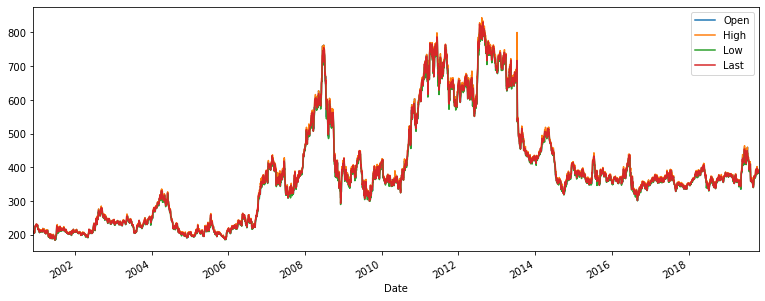

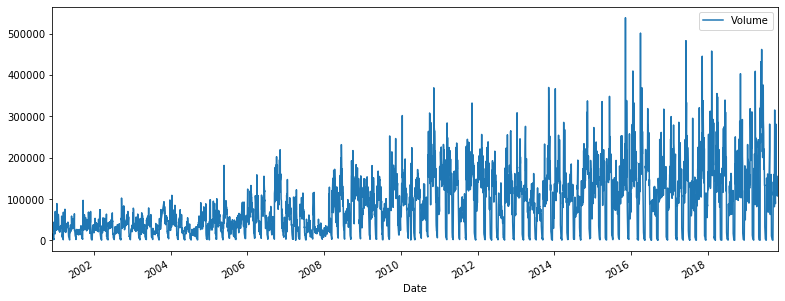

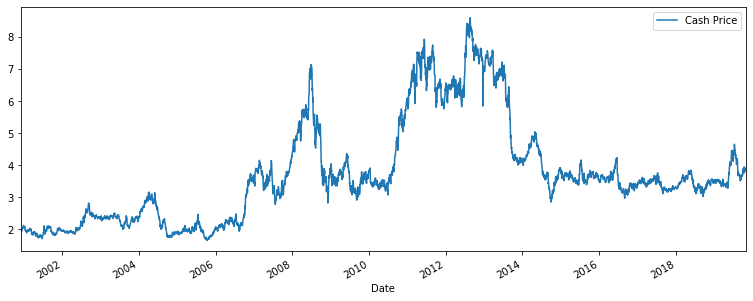

In [8]:
futures_p_df[['Open', 'High', 'Low', 'Last']].plot(figsize=(13,5))
futures_p_df[['Volume']].plot(figsize=(13,5))
spot_p_df[['Cash Price']].plot(figsize=(13,5))

#### Normalize

In [9]:
norm_futures_p_df=(futures_p_df-futures_p_df.mean())/futures_p_df.std()
norm_spot_p_df=(spot_p_df-spot_p_df.mean())/spot_p_df.std()
print(norm_futures_p_df.columns)

Index(['Open', 'High', 'Low', 'Last', 'Settle', 'Volume',
       'Previous Day Open Interest'],
      dtype='object')


### Do regression and calculate residuals

In [10]:
x = np.array(list(range(M))).reshape(-1,1)
fut_data = norm_futures_p_df[['Settle', 'Volume']].values
reg_fut = LinearRegression().fit(x, fut_data)
delta = fut_data - reg_fut.predict(x)
v_hat = np.linalg.norm(delta, axis=1)**2
v_hat = v_hat.reshape(-1,1)

In [11]:
spot_data = norm_spot_p_df[['Cash Price']].values
reg_spot = LinearRegression().fit(x, spot_data)
delta = spot_data - reg_spot.predict(x)
u_hat = np.linalg.norm(delta, axis=1)**2
u_hat = u_hat.reshape(-1,1)

### Optimal hedge ratio estimator



In [12]:
r_hat = v_hat.T.dot(u_hat)/v_hat.T.dot(v_hat)

In [13]:
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[0.45904597]]


## Price only

In [14]:
x = np.array(list(range(M))).reshape(-1,1)
fut_data = norm_futures_p_df['Settle'].values
reg_fut = LinearRegression().fit(x, fut_data)
delta = fut_data - reg_fut.predict(x)
v_hat = np.linalg.norm(delta, axis=0)**2
v_hat = v_hat.reshape(-1,1)

In [15]:
spot_data = norm_spot_p_df['Cash Price'].values
reg_spot = LinearRegression().fit(x, spot_data)
delta = spot_data - reg_spot.predict(x)
u_hat = np.linalg.norm(delta, axis=0)**2
u_hat = u_hat.reshape(-1,1)

In [16]:
r_hat = v_hat.T.dot(u_hat)/v_hat.T.dot(v_hat)
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[1.01146204]]


### Estimate model corectness


In [17]:
from regression_estimates import get_predictions

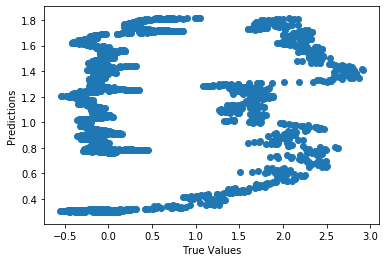

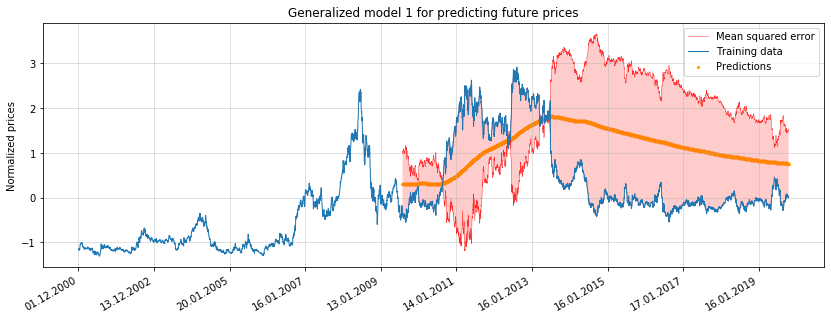

In [19]:
N_predictions = 365*7
predictions, scores, mses = get_predictions(x, fut_data, N_predictions, name="future", plot_index=norm_futures_p_df.index)

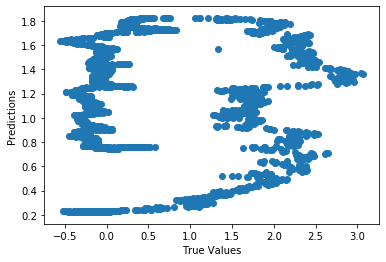

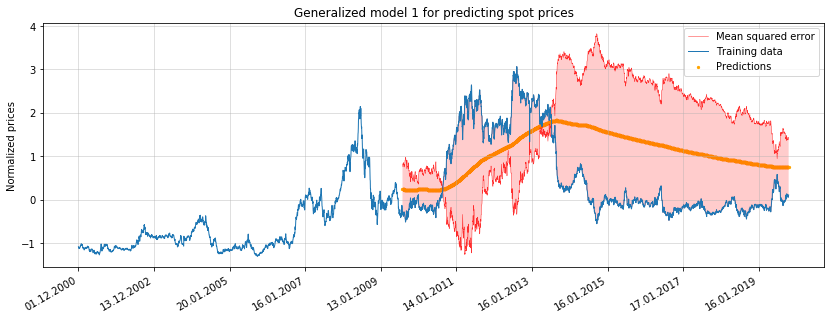

In [20]:
predictions, scores, mses = get_predictions(x, spot_data, N_predictions, name="spot", plot_index=norm_spot_p_df.index)


## Random walk

In [21]:
v_hat = norm_futures_p_df['Settle'].values - norm_futures_p_df['Settle'].values.mean()
v_hat = v_hat.reshape(-1,1)
u_hat = norm_spot_p_df['Cash Price'].values - norm_spot_p_df['Cash Price'].values.mean()
u_hat = u_hat.reshape(-1,1)

In [22]:
r_hat = v_hat.T.dot(u_hat)/v_hat.T.dot(v_hat)
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[0.99411263]]


## Simple

In [23]:
delta_p = (norm_futures_p_df['Settle'].values - np.concatenate(([0], norm_futures_p_df['Settle'].values))[:M])[:M-1]
delta_f = (norm_spot_p_df['Cash Price'].values - np.concatenate(([0], norm_spot_p_df['Cash Price'].values))[:M])[:M-1]

In [24]:
v_hat = delta_p - delta_p.mean()
v_hat = v_hat.reshape(-1,1)
u_hat = delta_f - delta_f.mean()
u_hat = u_hat.reshape(-1,1)

In [25]:
r_hat = v_hat.T.dot(u_hat)/v_hat.T.dot(v_hat)
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[0.8323498]]
